In [2]:
import pandas as pd
import numpy as np
from scipy.stats import mode, entropy
from datetime import datetime, timedelta
from collections import defaultdict
from pprint import pprint
import time, json, os, pickle

from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, fbeta_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve, average_precision_score, make_scorer

pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt

import sys
# reload(sys)
# sys.setdefaultencoding('utf-8')
os.chdir('/Users/meif/Desktop/SI 699')
% matplotlib inline 

This notebook is to compare the performance of droping a class of features at a time.

## 0. Prepare Dataset

In [12]:
# continuous and categorical

mains = ["user_coupon", "user_id", "coupon_id", "start_time", "is_used"]

categorical_all = ['sex_1', 'sex_2', 
               'age_60', 'age_70', 'age_80', 'age_90', 'age_0', 
               'city1', 'city2', 'city3', 'city4', 'city5', 
               'AppVerLast_2.1', 'AppVerLast_2.2', 'AppVerLast_2.3', 'AppVerLast_2.4', 'AppVerLast_2.5', 'AppVerLast_2.7', 'AppVerLast_2.8',
               'covers_mon', 'covers_tue', 'covers_wed', 'covers_thu', 'covers_fri', 'covers_sat', 'covers_sun', 
               'type1', 'type6', 
               'Complaints', 'Eventsoperation', 'NewUserCouponPackageByBD', 'PreUserCouponCode', 'RecallUserDaily', 'home201603222253', 
               'home_dongbeiguan', 'home_jiangzhecai', 'home_muqinjie', 'home_xiangcaiguan', 'preuser', 'shareuser', 
               '商家拒单返券', '家厨发券', '活动赠券', '码兑券', '自运营赠券', '蒲公英受邀',
               'CoupUseLast']

continuous_all = ['kitchen_entropy', 
              'distance_median', 'distance_std',
              'user_longitude_median', 'user_longitude_std', 'user_latitude_median', 'user_latitude_std', 
              'coupon_effective_days', 'money', 'max_money', 
              'WeeklyCouponUsedCount', "BiWeeklyCouponUsedCount",
              'WeeklyOrderCount', 'BiWeeklyOrderCount',
              'coupon_usage_rate', 'order_coupon_usage_rate',
              'coupon_type1_usage_rate', 'coupon_type6_usage_rate',
              'coupon_used_weekend_perc', 'order_weekend_perc', 
              'worth_money_median', 'worth_money_std', 
              'InterOrder_fillna_w_start_date', 'InterCoup_fillna_w_start_date', 'Recency_fillna_w_start_date']

group_remove_cate = [['sex_1', 'sex_2'], 
                     ['age_60', 'age_70', 'age_80', 'age_90', 'age_0'],
                     ['city1', 'city2', 'city3', 'city4', 'city5'],
                     ['AppVerLast_2.1', 'AppVerLast_2.2', 'AppVerLast_2.3', 'AppVerLast_2.4', 'AppVerLast_2.5', 'AppVerLast_2.7', 'AppVerLast_2.8'],
                     ['type1', 'type6'], 
                     ['Complaints', 'Eventsoperation', 'NewUserCouponPackageByBD', 'PreUserCouponCode', 'RecallUserDaily', 'home201603222253', 'home_dongbeiguan', 'home_jiangzhecai', 'home_muqinjie', 'home_xiangcaiguan', 'preuser', 'shareuser',  '商家拒单返券', '家厨发券', '活动赠券', '码兑券', '自运营赠券', '蒲公英受邀'], 
                     ['covers_mon', 'covers_tue', 'covers_wed', 'covers_thu', 'covers_fri', 'covers_sat', 'covers_sun']]

group_remove_cont = [['coupon_type1_usage_rate', 'coupon_type6_usage_rate', 'coupon_usage_rate', 'order_coupon_usage_rate', 'coupon_used_weekend_perc', 'order_weekend_perc'],
                     ['kitchen_entropy', 'distance_median', 'distance_std', 'user_longitude_median', 'user_longitude_std', 'user_latitude_median', 'user_latitude_std'],
                     ['coupon_effective_days'], 
                     ['money', 'max_money'],
                     ['CoupUseLast', 'WeeklyCouponUsedCount', "BiWeeklyCouponUsedCount"],
                     ['WeeklyOrderCount', 'BiWeeklyOrderCount', 'worth_money_median', 'worth_money_std'],
                     ['InterOrder_fillna_w_start_date', 'InterCoup_fillna_w_start_date', 'Recency_fillna_w_start_date']]

groups = ["Cont0","Cont1","Cont2","Cont3","Cont4","Cont5","Cont6"]
# groups = ["Cate0","Cate1","Cate2","Cate3","Cate4","Cate5","Cate6"]
continuous = continuous_all
categorical = categorical_all
# categorical = list(set(categorical_all) - set(group_remove_cate[5]))

In [5]:
trainset = pd.read_csv("Dataset/trainset_180314.csv").iloc[:,1:]
testset = pd.read_csv("Dataset/testset_180314.csv").iloc[:,1:]
print(len(trainset) + len(testset))
print(trainset.columns[5:].tolist())

5484528
['sex_1', 'sex_2', 'age_60', 'age_70', 'age_80', 'age_90', 'age_0', 'city1', 'city2', 'city3', 'city4', 'city5', 'AppVerLast_2.1', 'AppVerLast_2.2', 'AppVerLast_2.3', 'AppVerLast_2.4', 'AppVerLast_2.5', 'AppVerLast_2.7', 'AppVerLast_2.8', 'kitchen_entropy', 'distance_median', 'distance_std', 'user_longitude_median', 'user_longitude_std', 'user_latitude_median', 'user_latitude_std', 'coupon_effective_days', 'money', 'max_money', 'covers_mon', 'covers_tue', 'covers_wed', 'covers_thu', 'covers_fri', 'covers_sat', 'covers_sun', 'type1', 'type6', 'Complaints', 'Eventsoperation', 'NewUserCouponPackageByBD', 'PreUserCouponCode', 'RecallUserDaily', 'home201603222253', 'home_dongbeiguan', 'home_jiangzhecai', 'home_muqinjie', 'home_xiangcaiguan', 'preuser', 'shareuser', '商家拒单返券', '家厨发券', '活动赠券', '码兑券', '自运营赠券', '蒲公英受邀', 'coupon_usage_rate', 'order_coupon_usage_rate', 'coupon_type1_usage_rate', 'coupon_type6_usage_rate', 'coupon_used_weekend_perc', 'order_weekend_perc', 'worth_money_media

In [6]:
scaler = MinMaxScaler()
MODEL = "l2" # l1
SOLVER = "sag"
MAX_ITER = 2000
C = 0.1
BALANCE = 2
N_JOBS = 4
RANDOM_STATE = 42

In [7]:
# scaling
print("scaling..")
X_train_continuous = scaler.fit_transform(trainset[continuous])
X_test_continuous = scaler.transform(testset[continuous])

trainset_scaled = pd.concat([trainset.loc[:,mains + categorical], pd.DataFrame(X_train_continuous, columns = continuous)], axis=1)
testset_scaled = pd.concat([testset.loc[:,mains + categorical], pd.DataFrame(X_test_continuous, columns = continuous)], axis=1)

scaling..


In [8]:
# train & test
trainset_all = trainset_scaled
trainset_all = trainset_all.iloc[shuffle(trainset_all.index).tolist(),]

X_train_all = trainset_all.iloc[:,5:]
y_train_all = trainset_all["is_used"]
X_test = testset_scaled.iloc[:,5:]
y_test = testset_scaled["is_used"]

## 1. Logistic Regression | SVM

In [13]:
res_lm_analysis = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: list)))

evaluations = ["F05", "Precision", "Recall", "Mean_Pre", "AUC", "Accuracy"]
for g in groups:
    for ev in evaluations:
        res_lm_analysis[ev][str(g)] = 0

In [ ]:
# train
start_time = time.time()

for g in groups:
    
    if g.startswith("Cont"):
        # cont: 0~6
        continuous = list(set(continuous_all) - set(group_remove_cont[int(g[-1])]))
        categorical = categorical_all
        
        # scaling
        print("scaling..")
        X_train_continuous = scaler.fit_transform(trainset[continuous])
        X_test_continuous = scaler.transform(testset[continuous])

        trainset_scaled = pd.concat([trainset.loc[:,mains + categorical], pd.DataFrame(X_train_continuous, columns = continuous)], axis=1)
        testset_scaled = pd.concat([testset.loc[:,mains + categorical], pd.DataFrame(X_test_continuous, columns = continuous)], axis=1)

    else:
        # cate: 0~6
        continuous = continuous_all
        categorical = list(set(categorical_all) - set(group_remove_cate[int(g[-1])]))
        
        trainset_scaled = pd.concat([trainset.loc[:,mains + categorical], pd.DataFrame(X_train_continuous, columns = continuous)], axis=1)
        testset_scaled = pd.concat([testset.loc[:,mains + categorical], pd.DataFrame(X_test_continuous, columns = continuous)], axis=1)
        
    trainset_all = trainset_scaled
    trainset_all = trainset_all.iloc[shuffle(trainset_all.index).tolist(),]
    X_train_all = trainset_all.iloc[:,5:]
    y_train_all = trainset_all["is_used"]

    X_test = testset_scaled.iloc[:,5:]
    y_test = testset_scaled["is_used"]
     
    model = LogisticRegression(C=C, 
                               penalty=MODEL, solver=SOLVER, 
                               class_weight={1: BALANCE}, 
                               max_iter=MAX_ITER,
                               random_state=RANDOM_STATE, n_jobs=N_JOBS)
    print("fitting group {}..".format(g))
    model.fit(X_train_all, y_train_all)
    y_pred = model.predict(X_test)
    y_pred_proba = [i[1] for i in model.predict_proba(X_test)]

    print(confusion_matrix(y_test, y_pred, labels=[1,0]))
            
    f05 = fbeta_score(y_test, y_pred, beta=0.5, labels=[1,0])
    precision = precision_score(y_test, y_pred, labels=[1,0])
    recall = recall_score(y_test, y_pred, labels=[1,0])
    mp = average_precision_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    acc = accuracy_score(y_test, y_pred)
    evaluations_res = [f05, precision, recall, mp, auc, acc]

    for i in range(len(evaluations)):
        print("{}: {}".format(evaluations[i], evaluations_res[i]))
        res_lm_analysis[evaluations[i]][g] = evaluations_res[i]
    print("\n")
        
print("{} sec\n".format(time.time() - start_time))

In [ ]:
# save param output
with open('ParamResults/LinearModels/json/res_lm_analysis.json', 'w') as f:
    json.dump(res_lm_analysis, f)

# 2. Evaluation

In [27]:
# load params
res_lr_l1_minmax_1v2_all = json.load(open("ParamResults/LinearModels/json/reduced/res_lr_l1_1_1v2_all.json"))
res_lr_l2_minmax_1v2_all = json.load(open("ParamResults/LinearModels/json/reduced/res_lr_l2_1_1v2_all.json"))
res_lr_l2_minmax_1v2_g1 = json.load(open("ParamResults/LinearModels/json/reduced/res_lr_l2_1_1v2_group1.json"))
res_lr_l2_minmax_1v2_g2 = json.load(open("ParamResults/LinearModels/json/reduced/res_lr_l2_1_1v2_group2.json"))
res_lr_l2_stdard_1v2_g1 = json.load(open("ParamResults/LinearModels/json/reduced/res_lr_l2_2_1v2_group1.json"))
res_lr_l2_stdard_1v2_g2 = json.load(open("ParamResults/LinearModels/json/reduced/res_lr_l2_2_1v2_group2.json"))
res_lr_l2_svm_1v2_g1 = json.load(open("ParamResults/LinearModels/json/reduced/res_lr_svm_1_1v2_group1.json"))
res_lr_l2_svm_1v2_g2 = json.load(open("ParamResults/LinearModels/json/reduced/res_lr_svm_1_1v2_group2.json"))

evaluations = ["F05", "Precision", "Recall", "Mean_Pre", "AUC", "Accuracy"]
l1_c = ["0.01", "0.05", "0.1", "0.5"]
l2_c = ["0.01", "0.1", "1", "10"]

plot_lr_l1_minmax_1v2 = {ev: [res_lr_l1_minmax_1v2_all[ev][c] for c in l1_c] for ev in evaluations}
plot_lr_l2_minmax_1v2 = {ev: [res_lr_l2_minmax_1v2_all[ev][c] for c in l2_c] for ev in evaluations}
plot_lr_l2_minmax_1v2_g1 = {ev: [res_lr_l2_minmax_1v2_g1[ev][c] for c in l2_c] for ev in evaluations}
plot_lr_l2_minmax_1v2_g2 = {ev: [res_lr_l2_minmax_1v2_g2[ev][c] for c in l2_c] for ev in evaluations}
plot_lr_l2_stdard_1v2_g1 = {ev: [res_lr_l2_stdard_1v2_g1[ev][c] for c in l2_c] for ev in evaluations}
plot_lr_l2_stdard_1v2_g2 = {ev: [res_lr_l2_stdard_1v2_g2[ev][c] for c in l2_c] for ev in evaluations}
plot_lr_l2_svm_1v2_g1 = {ev: [res_lr_l2_svm_1v2_g1[ev][c] for c in l2_c] for ev in evaluations}
plot_lr_l2_svm_1v2_g2 = {ev: [res_lr_l2_svm_1v2_g2[ev][c] for c in l2_c] for ev in evaluations}

In [21]:
a = pd.DataFrame(res_lr_l2_stdard_1v2_g2, index=None)
a = a[["SCALER","F05","Precision","Recall","Accuracy","AUC","Mean_Pre"]]
a

,SCALER,F05,Precision,Recall,Accuracy,AUC,Mean_Pre
0.01,2,0.396802,0.377279,0.535769,0.872706,0.855986,0.237500
0.1,2,0.400299,0.379371,0.548681,0.873842,0.857961,0.242338
1,2,0.400852,0.379969,0.548795,0.874147,0.858399,0.242702
10,2,0.400842,0.379962,0.548775,0.874150,0.858435,0.242688


/Users/meif/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


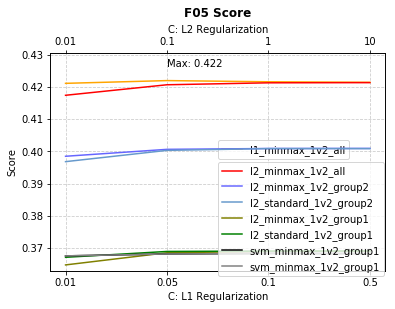

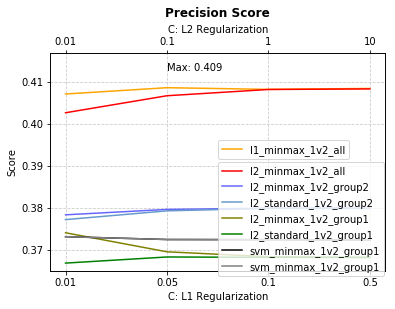

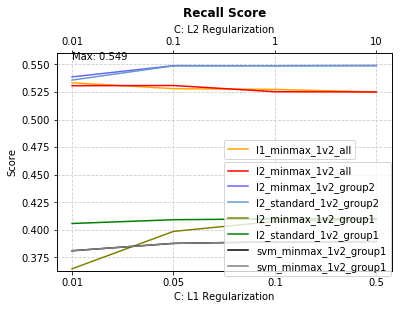

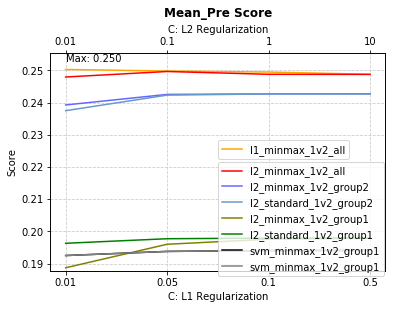

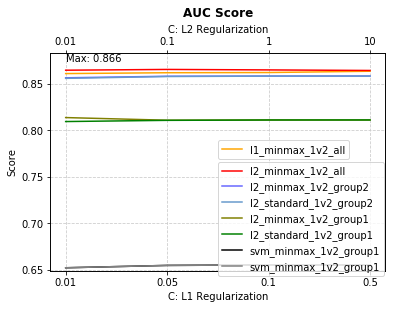

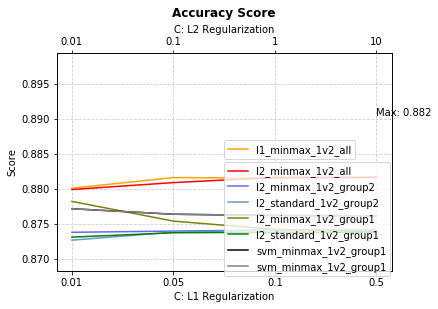

In [28]:
# plot
for i in range(len(evaluations)):
    fig = plt.figure(i + 1)
    
    plt.title(evaluations[i] + " Score", y=1.14, fontweight="bold")
    plt.grid(True, linestyle='--', color='#CCCCCC')
    
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twiny()
    
    ax1_1 = plot_lr_l1_minmax_1v2[evaluations[i]]
    ax2_1 = plot_lr_l2_minmax_1v2[evaluations[i]]
    ax2_2 = plot_lr_l2_minmax_1v2_g1[evaluations[i]]
    ax2_3 = plot_lr_l2_minmax_1v2_g2[evaluations[i]]
    ax2_4 = plot_lr_l2_stdard_1v2_g1[evaluations[i]]
    ax2_5 = plot_lr_l2_stdard_1v2_g2[evaluations[i]]
    ax2_6 = plot_lr_l2_svm_1v2_g1[evaluations[i]]
    ax2_7 = plot_lr_l2_svm_1v2_g1[evaluations[i]]
    maxIdx = np.argmax(np.array(ax1_1+ax2_1+ax2_2+ax2_3+ax2_4+ax2_5+ax2_6+ax2_7))
    maxScore = max(ax1_1+ax2_1+ax2_2+ax2_3+ax2_4+ax2_5+ax2_6+ax2_7)
    minScore = min(ax1_1+ax2_1+ax2_2+ax2_3+ax2_4+ax2_5+ax2_6+ax2_7)
    
    ax1.set_ylabel('Score')
    ax1.set_xlabel('C: L1 Regularization')
    ax1.set_ylim(minScore*0.995, maxScore*1.02)
    ax1.set_xticks(range(5))
    ax1.set_xticklabels(l1_c)
    ax1.plot(ax1_1, label="l1_minmax_1v2_all", color='orange')
    ax1.legend(bbox_to_anchor=(0.5, 0.6), loc=2, borderaxespad=0.)

    ax2.set_xlabel('C: L2 Regularization')
    ax2.set_xticks(range(6))
    ax2.set_xticklabels(l2_c)
    ax2.plot(ax2_1, label="l2_minmax_1v2_all", color='red')
    ax2.plot(ax2_3, label="l2_minmax_1v2_group2", color='#6666FF')
    ax2.plot(ax2_5, label="l2_standard_1v2_group2", color='#6699CC')
    ax2.plot(ax2_2, label="l2_minmax_1v2_group1", color='olive')
    ax2.plot(ax2_4, label="l2_standard_1v2_group1", color='green')
    ax2.plot(ax2_6, label="svm_minmax_1v2_group1", color='black')
    ax2.plot(ax2_7, label="svm_minmax_1v2_group1", color='grey')
    ax2.legend(bbox_to_anchor=(0.5, 0.5), loc=2, borderaxespad=0.)

    plt.text(maxIdx%5, 
             maxScore*1.01, 
             'Max: {0:.3f}'.format(maxScore))
    
    plt.savefig('ParamResults/LinearModels/plots/LinearModels_{}_reduced.png'.format(evaluations[i]))
    plt.show()

# 3. Prediction

In [52]:
# all
categorical = categorical_all
continuous = continuous_all

# scaling
X_train_continuous = scaler.fit_transform(trainset[continuous])
X_test_continuous = scaler.transform(testset[continuous])

trainset_scaled = pd.concat([trainset.loc[:,mains + categorical], pd.DataFrame(X_train_continuous, columns = continuous)], axis=1)
testset_scaled = pd.concat([testset.loc[:,mains + categorical], pd.DataFrame(X_test_continuous, columns = continuous)], axis=1)

# shuffle
trainset_all = trainset_scaled
trainset_all = trainset_all.iloc[shuffle(trainset_all.index).tolist(),]
X_train_all = trainset_all.iloc[:,5:]
y_train_all = trainset_all["is_used"]

X_test = testset_scaled.iloc[:,5:]
y_test = testset_scaled["is_used"]

In [60]:
# retrain using selected params
TRAIN_MODEL = False
if TRAIN_MODEL:
    c, p, s, b, mi, rs, nj = 0.1, 'l2', 'sag', 2, 1000, 42, 4
    lr2_all_best = LogisticRegression(C=c,
                                 penalty=p, solver=s, 
                                 class_weight={1: b}, 
                                 max_iter=mi,
                                 random_state=rs, n_jobs=nj)
    lr2_all_best.fit(X_train_all, y_train_all)
    pickle.dump(lr2_all_best, open('feature_selection_lr_l2_all_best.sav', 'wb'))
else:
    lr2_all_best = pickle.load(open('feature_selection_lr_l2_all_best.sav', 'rb'))
    
y_pred_lr2_all_best = lr2_all_best.predict(X_test)
y_pred_proba_lr2_all_best = lr2_all_best.predict_proba(X_test)
lr2_all_best

LogisticRegression(C=0.1, class_weight={1: 2}, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=4,
          penalty='l2', random_state=42, solver='sag', tol=0.0001,
          verbose=0, warm_start=False)

In [61]:
print(confusion_matrix(y_test, y_pred_lr2_all_best, labels=[1,0]))
print("F05: {}".format(fbeta_score(y_test, y_pred_lr2_all_best, beta=0.5, labels=[1,0])))
print("Precision: {}".format(precision_score(y_test, y_pred_lr2_all_best, labels=[1,0])))
print("Recall: {}".format(recall_score(y_test, y_pred_lr2_all_best, labels=[1,0])))
print("Mean_Pre: {}".format(average_precision_score(y_test, y_pred_lr2_all_best)))
print("AUC: {}".format(roc_auc_score(y_test, [i[1] for i in y_pred_proba_lr2_all_best])))
print("Accuracy: {}".format(accuracy_score(y_test, y_pred_lr2_all_best)))

[[108931  58024]
 [146251 748792]]
F05: 0.45858617156261394
Precision: 0.4268757200742999
Recall: 0.6524572489593005
Mean_Pre: 0.33315479570097917
AUC: 0.8463149443976136
Accuracy: 0.8076502968932144


In [62]:
# retrain using selected params
TRAIN_MODEL = False
if TRAIN_MODEL:
    c, p, s, b, mi, rs, nj = 0.05, 'l1', 'saga', 2, 1000, 42, 4
    lr1_all_best = LogisticRegression(C=c,
                                 penalty=p, solver=s, 
                                 class_weight={1: b}, 
                                 max_iter=mi,
                                 random_state=rs, n_jobs=nj)
    lr1_all_best.fit(X_train_all, y_train_all)
    pickle.dump(lr1_all_best, open('feature_selection_lr_l1_all_best.sav', 'wb'))
else:
    lr1_all_best = pickle.load(open('feature_selection_lr_l1_all_best.sav', 'rb'))
    
y_pred_lr1_all_best = lr1_all_best.predict(X_test)
y_pred_proba_lr1_all_best = lr1_all_best.predict_proba(X_test)
lr1_all_best

LogisticRegression(C=0.05, class_weight={1: 2}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='ovr', n_jobs=4, penalty='l1', random_state=42,
          solver='saga', tol=0.0001, verbose=0, warm_start=False)

In [63]:
print(confusion_matrix(y_test, y_pred_lr1_all_best, labels=[1,0]))
print("F05: {}".format(fbeta_score(y_test, y_pred_lr1_all_best, beta=0.5, labels=[1,0])))
print("Precision: {}".format(precision_score(y_test, y_pred_lr1_all_best, labels=[1,0])))
print("Recall: {}".format(recall_score(y_test, y_pred_lr1_all_best, labels=[1,0])))
print("Mean_Pre: {}".format(average_precision_score(y_test, y_pred_lr1_all_best)))
print("AUC: {}".format(roc_auc_score(y_test, [i[1] for i in y_pred_proba_lr1_all_best])))
print("Accuracy: {}".format(accuracy_score(y_test, y_pred_lr1_all_best)))

[[107953  59002]
 [144264 750779]]
F05: 0.45905293568844974
Precision: 0.4280163509993379
Recall: 0.6465993830672936
Mean_Pre: 0.332312651921755
AUC: 0.8462015292028731
Accuracy: 0.808600392844431


In [67]:
# group2
categorical = categorical_gourp2
continuous = continuous_gourp2

# scaling
X_train_continuous = scaler.fit_transform(trainset[continuous])
X_test_continuous = scaler.transform(testset[continuous])

trainset_scaled = pd.concat([trainset.loc[:,mains + categorical], pd.DataFrame(X_train_continuous, columns = continuous)], axis=1)
testset_scaled = pd.concat([testset.loc[:,mains + categorical], pd.DataFrame(X_test_continuous, columns = continuous)], axis=1)

# shuffle
trainset_all = trainset_scaled
trainset_all = trainset_all.iloc[shuffle(trainset_all.index).tolist(),]
X_train_all = trainset_all.iloc[:,5:]
y_train_all = trainset_all["is_used"]

X_test = testset_scaled.iloc[:,5:]
y_test = testset_scaled["is_used"]

In [68]:
# retrain using selected params
TRAIN_MODEL = False
if TRAIN_MODEL:
    c, p, s, b, mi, rs, nj = 0.1, 'l2', 'sag', 2, 1000, 42, 4
    lr2_reduced_best = LogisticRegression(C=c,
                                 penalty=p, solver=s, 
                                 class_weight={1: b}, 
                                 max_iter=mi,
                                 random_state=rs, n_jobs=nj)
    lr2_reduced_best.fit(X_train_all, y_train_all)
    pickle.dump(lr2_reduced_best, open('feature_selection_lr_l2_reduced_best.sav', 'wb'))
else:
    lr2_reduced_best = pickle.load(open('feature_selection_lr_l2_reduced_best.sav', 'rb'))
    
y_pred_lr2_reduced_best = lr2_reduced_best.predict(X_test)
y_pred_proba_lr2_reduced_best = lr2_reduced_best.predict_proba(X_test)
lr2_reduced_best

LogisticRegression(C=0.1, class_weight={1: 2}, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=4,
          penalty='l2', random_state=42, solver='sag', tol=0.0001,
          verbose=0, warm_start=False)

In [69]:
print(confusion_matrix(y_test, y_pred_lr2_reduced_best, labels=[1,0]))
print("F05: {}".format(fbeta_score(y_test, y_pred_lr2_reduced_best, beta=0.5, labels=[1,0])))
print("Precision: {}".format(precision_score(y_test, y_pred_lr2_reduced_best, labels=[1,0])))
print("Recall: {}".format(recall_score(y_test, y_pred_lr2_reduced_best, labels=[1,0])))
print("Mean_Pre: {}".format(average_precision_score(y_test, y_pred_lr2_reduced_best)))
print("AUC: {}".format(roc_auc_score(y_test, [i[1] for i in y_pred_proba_lr2_reduced_best])))
print("Accuracy: {}".format(accuracy_score(y_test, y_pred_lr2_reduced_best)))

[[111054  55901]
 [152467 742576]]
F05: 0.45475205951652653
Precision: 0.4214237195517625
Recall: 0.6651732502770208
Mean_Pre: 0.3329573608667321
AUC: 0.8463384030125723
Accuracy: 0.8037962406708864


In [72]:
# retrain using selected params
TRAIN_MODEL = False
if TRAIN_MODEL:
    c, p, s, b, mi, rs, nj = 0.05, 'l1', 'saga', 2, 1000, 42, 4
    lr1_reduced_best = LogisticRegression(C=c,
                                 penalty=p, solver=s, 
                                 class_weight={1: b}, 
                                 max_iter=mi,
                                 random_state=rs, n_jobs=nj)
    lr1_reduced_best.fit(X_train_all, y_train_all)
    pickle.dump(lr1_reduced_best, open('feature_selection_lr_l1_reduced_best.sav', 'wb'))
else:
    lr1_reduced_best = pickle.load(open('feature_selection_lr_l1_reduced_best.sav', 'rb'))
    
y_pred_lr1_reduced_best = lr1_reduced_best.predict(X_test)
y_pred_proba_lr1_reduced_best = lr1_reduced_best.predict_proba(X_test)
lr1_reduced_best

LogisticRegression(C=0.05, class_weight={1: 2}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='ovr', n_jobs=4, penalty='l1', random_state=42,
          solver='saga', tol=0.0001, verbose=0, warm_start=False)

In [73]:
print(confusion_matrix(y_test, y_pred_lr1_reduced_best, labels=[1,0]))
print("F05: {}".format(fbeta_score(y_test, y_pred_lr1_reduced_best, beta=0.5, labels=[1,0])))
print("Precision: {}".format(precision_score(y_test, y_pred_lr1_reduced_best, labels=[1,0])))
print("Recall: {}".format(recall_score(y_test, y_pred_lr1_reduced_best, labels=[1,0])))
print("Mean_Pre: {}".format(average_precision_score(y_test, y_pred_lr1_reduced_best)))
print("AUC: {}".format(roc_auc_score(y_test, [i[1] for i in y_pred_proba_lr1_reduced_best])))
print("Accuracy: {}".format(accuracy_score(y_test, y_pred_lr1_reduced_best)))

[[111036  55919]
 [152705 742338]]
F05: 0.4543509021465416
Precision: 0.42100393947092035
Recall: 0.6650654367943458
Mean_Pre: 0.3326496936694843
AUC: 0.846334190839784
Accuracy: 0.8035551856029861


In [84]:
# group1
categorical = categorical_gourp1
continuous = continuous_gourp1

# scaling
X_train_continuous = scaler.fit_transform(trainset[continuous])
X_test_continuous = scaler.transform(testset[continuous])

trainset_scaled = pd.concat([trainset.loc[:,mains + categorical], pd.DataFrame(X_train_continuous, columns = continuous)], axis=1)
testset_scaled = pd.concat([testset.loc[:,mains + categorical], pd.DataFrame(X_test_continuous, columns = continuous)], axis=1)

# shuffle
trainset_all = trainset_scaled
trainset_all = trainset_all.iloc[shuffle(trainset_all.index).tolist(),]
X_train_all = trainset_all.iloc[:,5:]
y_train_all = trainset_all["is_used"]

X_test = testset_scaled.iloc[:,5:]
y_test = testset_scaled["is_used"]

In [85]:
# retrain using selected params
TRAIN_MODEL = False
if TRAIN_MODEL:
    c, p, s, b, mi, rs, nj = 0.1, 'l2', 'sag', 2, 1000, 42, 4
    lr2_group1_best = LogisticRegression(C=c,
                                 penalty=p, solver=s, 
                                 class_weight={1: b}, 
                                 max_iter=mi,
                                 random_state=rs, n_jobs=nj)
    lr2_group1_best.fit(X_train_all, y_train_all)
    pickle.dump(lr2_group1_best, open('feature_selection_lr_l2_group1_best.sav', 'wb'))
else:
    lr2_group1_best = pickle.load(open('feature_selection_lr_l2_group1_best.sav', 'rb'))
    
y_pred_lr2_group1_best = lr2_group1_best.predict(X_test)
y_pred_proba_lr2_group1_best = lr2_group1_best.predict_proba(X_test)
lr2_group1_best

LogisticRegression(C=0.1, class_weight={1: 2}, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=4,
          penalty='l2', random_state=42, solver='sag', tol=0.0001,
          verbose=0, warm_start=False)

In [87]:
print(confusion_matrix(y_test, y_pred_lr2_group1_best, labels=[1,0]))
print("F05: {}".format(fbeta_score(y_test, y_pred_lr2_group1_best, beta=0.5, labels=[1,0])))
print("Precision: {}".format(precision_score(y_test, y_pred_lr2_group1_best, labels=[1,0])))
print("Recall: {}".format(recall_score(y_test, y_pred_lr2_group1_best, labels=[1,0])))
print("Mean_Pre: {}".format(average_precision_score(y_test, y_pred_lr2_group1_best)))
print("AUC: {}".format(roc_auc_score(y_test, [i[1] for i in y_pred_proba_lr2_group1_best])))
print("Accuracy: {}".format(accuracy_score(y_test, y_pred_lr2_group1_best)))

[[ 71844  95111]
 [ 84541 810502]]
F05: 0.4532773077432666
Precision: 0.4594046743613518
Recall: 0.4303195471833728
Mean_Pre: 0.2872493605195821
AUC: 0.7773768856312673
Accuracy: 0.8308358396155172


In [86]:
# retrain using selected params
TRAIN_MODEL = False
if TRAIN_MODEL:
    c, p, s, b, mi, rs, nj = 0.05, 'l1', 'saga', 2, 1000, 42, 4
    lr1_group1_best = LogisticRegression(C=c,
                                 penalty=p, solver=s, 
                                 class_weight={1: b}, 
                                 max_iter=mi,
                                 random_state=rs, n_jobs=nj)
    lr1_group1_best.fit(X_train_all, y_train_all)
    pickle.dump(lr1_group1_best, open('feature_selection_lr_l1_group1_best.sav', 'wb'))
else:
    lr1_group1_best = pickle.load(open('feature_selection_lr_l1_group1_best.sav', 'rb'))
    
y_pred_lr1_group1_best = lr1_group1_best.predict(X_test)
y_pred_proba_lr1_group1_best = lr1_group1_best.predict_proba(X_test)
lr1_group1_best

LogisticRegression(C=0.05, class_weight={1: 2}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='ovr', n_jobs=4, penalty='l1', random_state=42,
          solver='saga', tol=0.0001, verbose=0, warm_start=False)

In [88]:
print(confusion_matrix(y_test, y_pred_lr1_group1_best, labels=[1,0]))
print("F05: {}".format(fbeta_score(y_test, y_pred_lr1_group1_best, beta=0.5, labels=[1,0])))
print("Precision: {}".format(precision_score(y_test, y_pred_lr1_group1_best, labels=[1,0])))
print("Recall: {}".format(recall_score(y_test, y_pred_lr1_group1_best, labels=[1,0])))
print("Mean_Pre: {}".format(average_precision_score(y_test, y_pred_lr1_group1_best)))
print("AUC: {}".format(roc_auc_score(y_test, [i[1] for i in y_pred_proba_lr1_group1_best])))
print("Accuracy: {}".format(accuracy_score(y_test, y_pred_lr1_group1_best)))

[[ 72015  94940]
 [ 85111 809932]]
F05: 0.45266317937190975
Precision: 0.45832643865432837
Recall: 0.431343775268785
Mean_Pre: 0.287093788176749
AUC: 0.7774348124445147
Accuracy: 0.8304601326932819


In [89]:
fpr_l2_all, tpr_l2_all, _ = roc_curve(y_test, np.array([i[1] for i in y_pred_proba_lr2_all_best]), pos_label=1)
fpr_l1_all, tpr_l1_all, _ = roc_curve(y_test, np.array([i[1] for i in y_pred_proba_lr1_all_best]), pos_label=1)
fpr_l2_reduced, tpr_l2_reduced, _ = roc_curve(y_test, np.array([i[1] for i in y_pred_proba_lr2_reduced_best]), pos_label=1)
fpr_l1_reduced, tpr_l1_reduced, _ = roc_curve(y_test, np.array([i[1] for i in y_pred_proba_lr1_reduced_best]), pos_label=1)
fpr_l2_group1, tpr_l2_group1, _ = roc_curve(y_test, np.array([i[1] for i in y_pred_proba_lr2_group1_best]), pos_label=1)
fpr_l1_group1, tpr_l1_group1, _ = roc_curve(y_test, np.array([i[1] for i in y_pred_proba_lr1_group1_best]), pos_label=1)

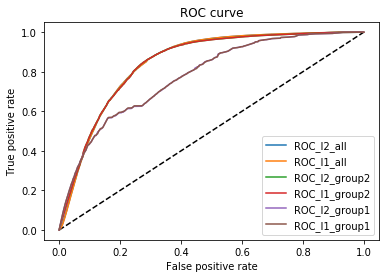

In [90]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_l2_all, tpr_l2_all, label='ROC_l2_all')
plt.plot(fpr_l1_all, tpr_l1_all, label='ROC_l1_all')
plt.plot(fpr_l2_reduced, tpr_l2_reduced, label='ROC_l2_group2')
plt.plot(fpr_l1_reduced, tpr_l1_reduced, label='ROC_l1_group2')
plt.plot(fpr_l2_group1, tpr_l2_group1, label='ROC_l2_group1')
plt.plot(fpr_l1_group1, tpr_l1_group1, label='ROC_l1_group1')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
# t test
model = LogisticRegression(C=0.1, 
                           penalty="l2", solver="sag", 
                           class_weight={1: 2}, 
                           max_iter=2000,
                           random_state=42, n_jobs=4)
model.fit(X_train_all, y_train_all)
y_pred = model.predict(X_test)
y_pred_proba = [i[1] for i in model.predict_proba(X_test)]

print(confusion_matrix(y_test, y_pred, labels=[1,0]))
print(fbeta_score(y_test, y_pred, beta=0.5, labels=[1,0]))
print(precision_score(y_test, y_pred, labels=[1,0]))
print(recall_score(y_test, y_pred, labels=[1,0]))
print(average_precision_score(y_test, y_pred))
print(roc_auc_score(y_test, y_pred_proba))
print(accuracy_score(y_test, y_pred))

from scipy.stats import ttest_rel
print(ttest_rel(y_pred_proba_all, y_pred_proba_rm5))
print(ttest_rel(y_pred_proba_all, y_pred_proba_rm6))